In [1]:
from pathlib import Path
from collections.abc import Mapping

import torch
import ignite
import ignite.distributed as idist
from ignite.contrib.engines import common
from ignite.engine import Engine, Events, create_supervised_evaluator, create_supervised_trainer
from ignite.handlers import DiskSaver
from ignite.metrics import ConfusionMatrix as cm, IoU, mIoU, Loss
from ignite.utils import setup_logger

import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [17]:
import sys

from models.unets import unet_resnet
from dataflow.dataloaders import get_train_val_loaders
from dataflow.visualisations import tensor_to_rgb
from dataflow.transforms import get_train_augmentation, get_validation_augmentation, prepare_batch_fp32, get_preprocessing
from metrics.iou import IoU as CustomIou
from tqdm import tqdm
loss = smp.utils.losses.DiceLoss()

In [18]:
model, preprocessing_function = unet_resnet('efficientnet-b0')

In [19]:
lr = 5e-4
optimizer = torch.optim.Adam(
    [
        {"params": model.encoder.parameters(), "lr": 1e-6},
        {"params": model.decoder.parameters(), "lr": lr / 10},
        {"params": model.segmentation_head.parameters(), "lr": lr},
    ],
    lr=lr,
)

In [20]:
num_epochs = 10

criterion = smp.utils.losses.DiceLoss()


In [21]:
debug=False

num_classes = 1

batch_size = 8 * idist.get_world_size()  # total batch size
val_batch_size = batch_size * 2
num_workers = 12
val_interval = 3
accumulation_steps = 4

val_img_size = 512
train_img_size = 512
data_dir = Path('/media/wwymak/Storage/spacenet/AOI_3_Paris_Train')
image_dir = data_dir / 'RGB-PanSharpen'
mask_dir = data_dir / 'masks'
summary_data_filepath = data_dir / 'summaryData' / 'AOI_3_Paris_Train_Building_Solutions.csv'
train_loader, val_loader, train_eval_loader = get_train_val_loaders(
    image_dir=image_dir,
    mask_dir=mask_dir,
    summary_data_filepath=summary_data_filepath,
    train_transforms=get_train_augmentation(train_img_size),
    val_transforms=get_validation_augmentation(train_img_size),
    train_preprocessing=get_preprocessing(preprocessing_function),
    val_preprocessing=get_preprocessing(preprocessing_function),
    train_ratio=0.8,
    batch_size=batch_size,
    num_workers=num_workers,
    limit_train_num_samples=100 if debug else None,
    limit_val_num_samples=100 if debug else None,
)

(17148, 4)
(16633, 4)


In [22]:
batch_train = (next(iter(train_loader)))
batch_val = (next(iter(val_loader)))
batch_train_val = (next(iter(train_eval_loader)))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/wwymak/udacity-ml-eng/project_satellite_segmentation/modelling/dataflow/datasets.py", line 30, in __getitem__
    preprocesed = self.preprocessing(image=img, mask=mask)
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/albumentations/core/composition.py", line 176, in __call__
    data = t(force_apply=force_apply, **data)
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/albumentations/core/transforms_interface.py", line 87, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/albumentations/core/transforms_interface.py", line 100, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/albumentations/augmentations/transforms.py", line 2972, in apply
    return fn(img, **params)
TypeError: __init__() got an unexpected keyword argument 'cols'


In [12]:
batch_train['image'].shape, batch_train['mask'].shape

NameError: name 'batch_train' is not defined

In [28]:
batch_train['image'].max()

tensor(0.8751)

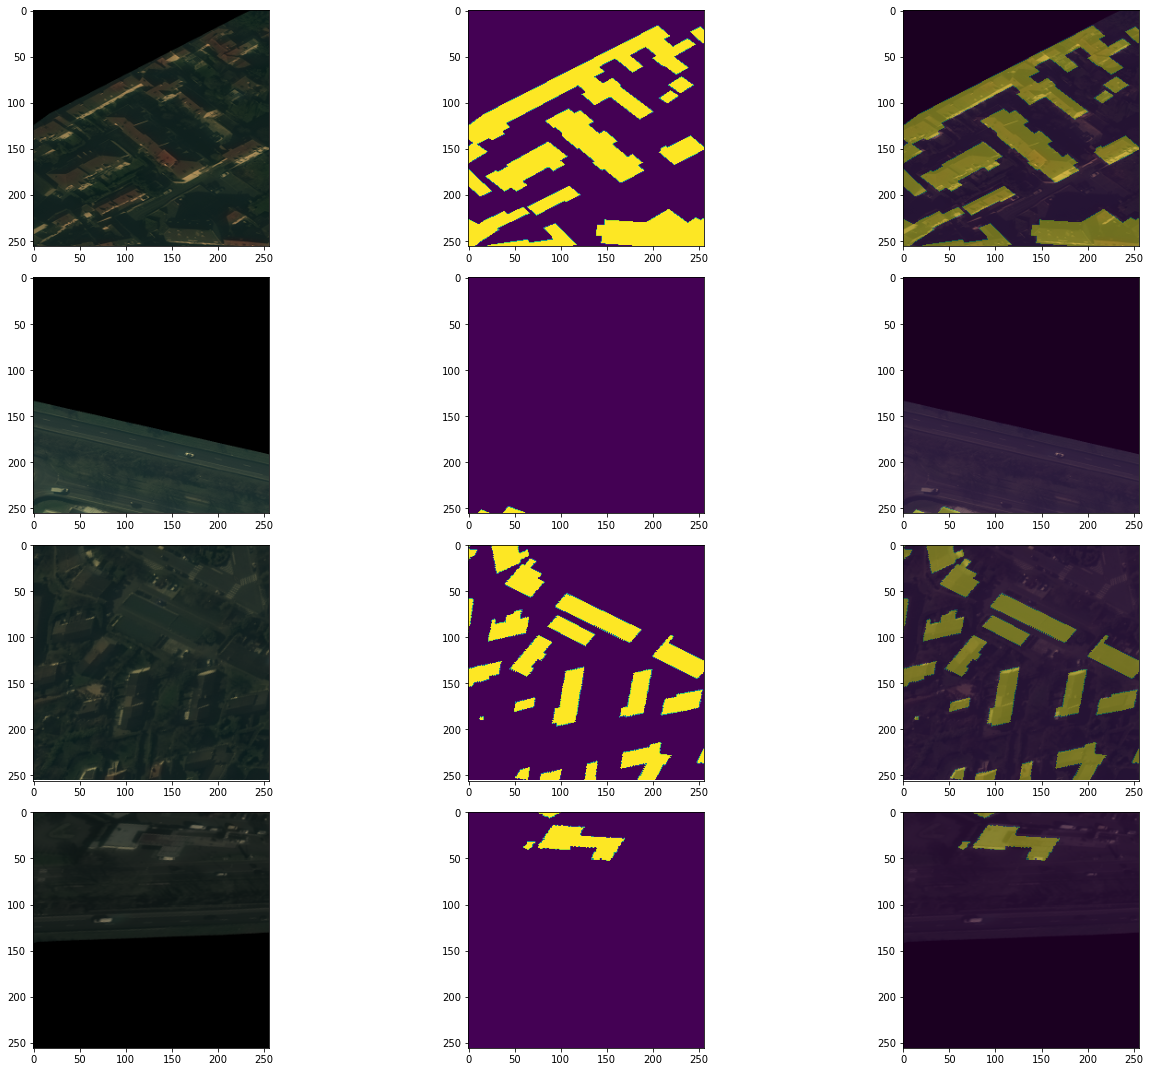

In [29]:
nrows=4
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(nrows * 5, 3 * 5))
for i in range(nrows):
    axs[i, 0].imshow(tensor_to_rgb(batch_train['image'][i]))
    axs[i, 1].imshow(batch_train['mask'][i])
    axs[i, 2].imshow(tensor_to_rgb(batch_train['image'][i]))
    axs[i, 2].imshow(batch_train['mask'][i], alpha=0.4)
plt.tight_layout()

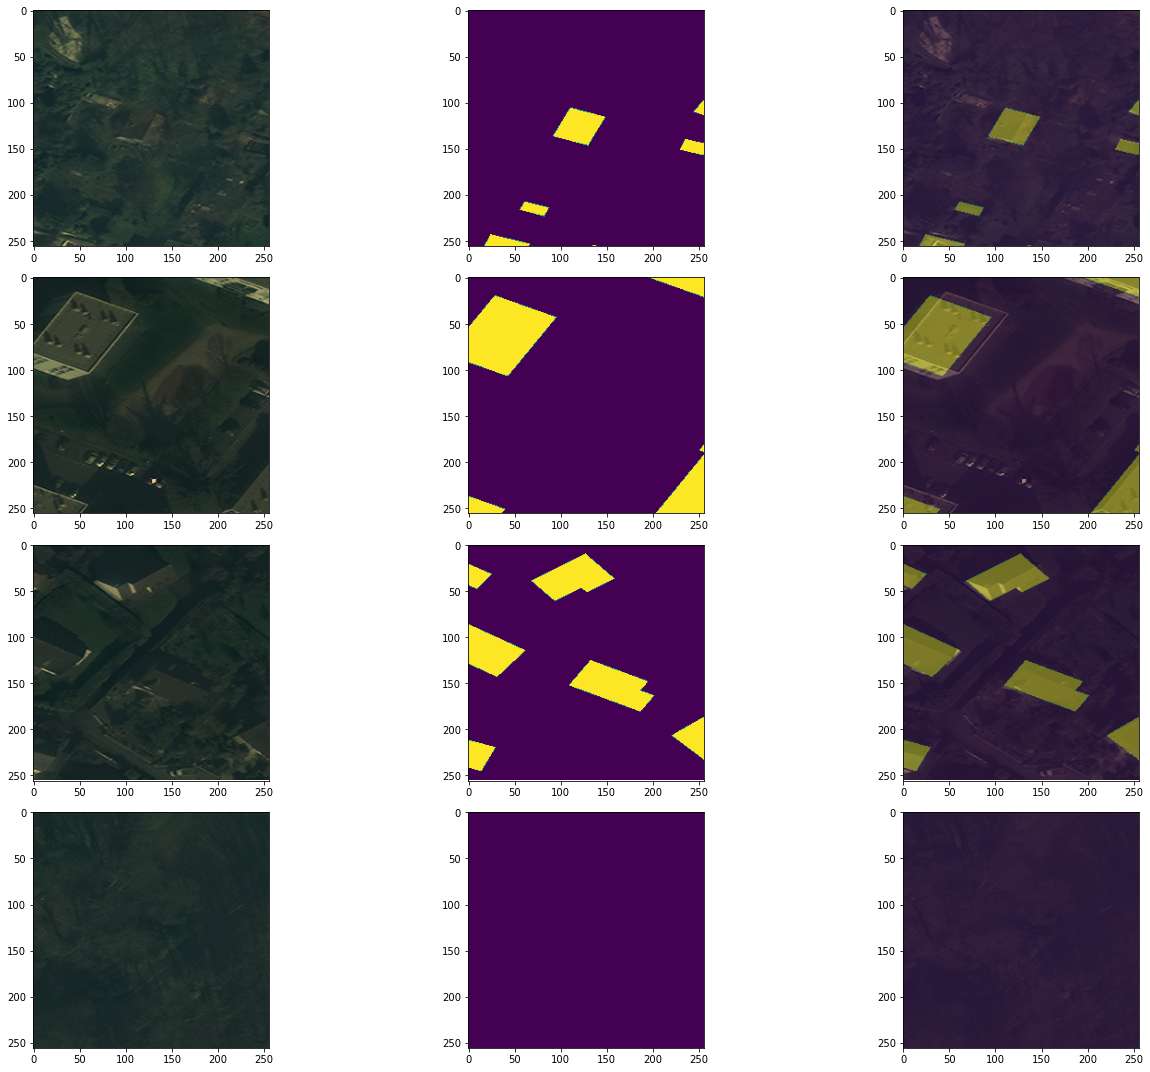

In [30]:
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(nrows * 5, 3 * 5))
for i in range(nrows):
    axs[i, 0].imshow(tensor_to_rgb(batch_val['image'][i]))
    axs[i, 1].imshow(batch_val['mask'][i])
    axs[i, 2].imshow(tensor_to_rgb(batch_val['image'][i]))
    axs[i, 2].imshow(batch_val['mask'][i], alpha=0.4)
plt.tight_layout()

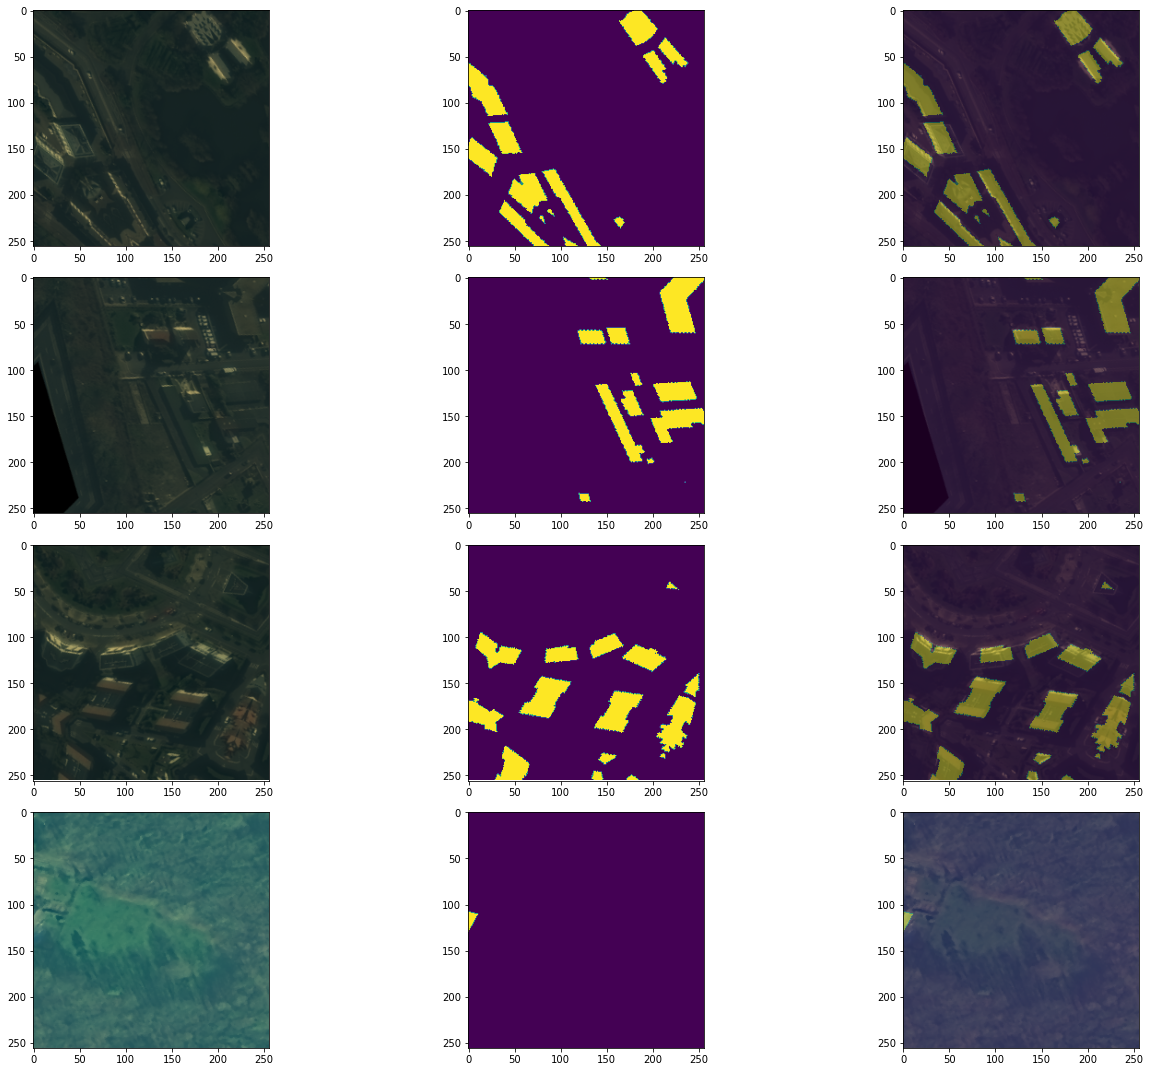

In [31]:
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(nrows * 5, 3 * 5))
for i in range(nrows):
    axs[i, 0].imshow(tensor_to_rgb(batch_train_val['image'][i]))
    axs[i, 1].imshow(batch_train_val['mask'][i])
    axs[i, 2].imshow(tensor_to_rgb(batch_train_val['image'][i]))
    axs[i, 2].imshow(batch_train_val['mask'][i], alpha=0.4)
plt.tight_layout()

In [32]:
device='cuda:0'
trainer = create_supervised_trainer(model, optimizer, criterion, device=device, prepare_batch=prepare_batch_fp32)
trainer.logger = setup_logger("trainer")


In [33]:
num_classes = 1
log_interval=10
# cm_metric = ConfusionMatrix(num_classes=num_classes)
val_metrics = {
        "IoU": CustomIou(),
        "dice_loss": Loss(loss),
    }
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device, prepare_batch=prepare_batch_fp32)
evaluator.logger = setup_logger("evaluator")

desc = "ITERATION - loss: {:.2f}"
pbar = tqdm(initial=0, leave=False, total=len(train_loader), desc=desc.format(0))

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    pbar.desc = desc.format(engine.state.output)
    pbar.update(log_interval)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    pbar.refresh()
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    iou = metrics["IoU"]
    loss = metrics["dice_loss"]
    tqdm.write(
        f"Training Results - Epoch: { engine.state.epoch}  iou: {iou} Avg loss: {loss}"
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    iou = metrics["IoU"]
    loss = metrics["dice_loss"]
    tqdm.write(
        f"Validation Results - Epoch: { engine.state.epoch}  iou: {iou} Avg loss: {loss}"
    )

    pbar.n = pbar.last_print_n = 0

@trainer.on(Events.EPOCH_COMPLETED | Events.COMPLETED)
def log_time(engine):
    tqdm.write(
        "{} took {} seconds".format(trainer.last_event_name.name, trainer.state.times[trainer.last_event_name.name])
    )



ITERATION - loss: 0.00:   0%|          | 0/63 [00:00<?, ?it/s]

In [34]:
trainer.run(train_loader, max_epochs=10)
pbar.close()

2020-07-20 22:13:07,052 trainer INFO: Engine run starting with max_epochs=10.
ITERATION - loss: -0.97:  95%|█████████▌| 60/63 [00:06<00:00,  8.91it/s]2020-07-20 22:13:12,998 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:13:15,192 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:13:15,192 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: -0.97:  95%|█████████▌| 60/63 [00:09<00:00,  8.91it/s]2020-07-20 22:13:15,249 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(7.8877, device='cuda:0')
Training Results - Epoch: 1  iou: 0.12520086765289307 Avg loss: -0.6777464633896237


2020-07-20 22:13:16,061 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:13:16,062 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: -0.97:   0%|          | 0/63 [00:10<00:07,  8.91it/s] 2020-07-20 22:13:16,106 trainer INFO: Epoch[1] Complete. Time taken: 00:00:06


16 tensor(1.7246, device='cuda:0')
Validation Results - Epoch: 1  iou: 0.10778618603944778 Avg loss: -0.46657352090820553
EPOCH_COMPLETED took 5.767413377761841 seconds


ITERATION - loss: -0.83:  95%|█████████▌| 60/63 [00:15<00:00,  9.92it/s]2020-07-20 22:13:21,720 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:13:23,871 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:13:23,872 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: -0.83:  95%|█████████▌| 60/63 [00:17<00:00,  9.92it/s]2020-07-20 22:13:23,911 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(7.9240, device='cuda:0')
Training Results - Epoch: 2  iou: 0.12577791512012482 Avg loss: -0.7417141795158386


2020-07-20 22:13:24,711 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:13:24,711 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: -0.83:   0%|          | 0/63 [00:18<00:06,  9.92it/s] 2020-07-20 22:13:24,751 trainer INFO: Epoch[2] Complete. Time taken: 00:00:06


16 tensor(1.6463, device='cuda:0')
Validation Results - Epoch: 2  iou: 0.10289367288351059 Avg loss: -0.4448374256374329
EPOCH_COMPLETED took 5.612894296646118 seconds


ITERATION - loss: -0.66:  95%|█████████▌| 60/63 [00:24<00:00, 10.06it/s]2020-07-20 22:13:30,395 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:13:32,560 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:13:32,560 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: -0.66:  95%|█████████▌| 60/63 [00:26<00:00, 10.06it/s]2020-07-20 22:13:32,607 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(7.9501, device='cuda:0')
Training Results - Epoch: 3  iou: 0.1261926144361496 Avg loss: -0.7733044832471817


2020-07-20 22:13:33,366 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:13:33,366 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: -0.66:   0%|          | 0/63 [00:27<00:06, 10.06it/s] 2020-07-20 22:13:33,406 trainer INFO: Epoch[3] Complete. Time taken: 00:00:06


16 tensor(1.8501, device='cuda:0')
Validation Results - Epoch: 3  iou: 0.11562997847795486 Avg loss: -0.6232334764923636
EPOCH_COMPLETED took 5.642899751663208 seconds


ITERATION - loss: -1.30: 70it [00:33, 10.68it/s]                        2020-07-20 22:13:39,053 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:13:41,206 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:13:41,207 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: -1.30: 70it [00:35, 10.68it/s]2020-07-20 22:13:41,248 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(8.0098, device='cuda:0')
Training Results - Epoch: 4  iou: 0.12714038789272308 Avg loss: -0.790825817320082


2020-07-20 22:13:42,003 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:13:42,003 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: -1.30:   0%|          | 0/63 [00:36<00:05, 10.68it/s]2020-07-20 22:13:42,044 trainer INFO: Epoch[4] Complete. Time taken: 00:00:06


16 tensor(1.9961, device='cuda:0')
Validation Results - Epoch: 4  iou: 0.12475522607564926 Avg loss: -0.734972357749939
EPOCH_COMPLETED took 5.646257162094116 seconds


ITERATION - loss: -0.86:  95%|█████████▌| 60/63 [00:41<00:00, 10.15it/s]2020-07-20 22:13:47,728 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:13:49,884 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:13:49,885 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: -0.86:  95%|█████████▌| 60/63 [00:43<00:00, 10.15it/s]2020-07-20 22:13:49,929 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(7.9362, device='cuda:0')
Training Results - Epoch: 5  iou: 0.12597200274467468 Avg loss: -0.7755539228045751


2020-07-20 22:13:50,711 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:13:50,712 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: -0.86:   0%|          | 0/63 [00:44<00:06, 10.15it/s] 2020-07-20 22:13:50,752 trainer INFO: Epoch[5] Complete. Time taken: 00:00:06


16 tensor(1.8886, device='cuda:0')
Validation Results - Epoch: 5  iou: 0.11803730577230453 Avg loss: -0.668258770244328
EPOCH_COMPLETED took 5.682679891586304 seconds


ITERATION - loss: -0.15:  95%|█████████▌| 60/63 [00:50<00:00, 10.05it/s]2020-07-20 22:13:56,402 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:13:58,609 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:13:58,609 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: -0.15:  95%|█████████▌| 60/63 [00:52<00:00, 10.05it/s]2020-07-20 22:13:58,651 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(7.8996, device='cuda:0')
Training Results - Epoch: 6  iou: 0.12538990378379822 Avg loss: -0.7704163950587076


2020-07-20 22:13:59,444 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:13:59,444 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: -0.15:   0%|          | 0/63 [00:53<00:06, 10.05it/s] 2020-07-20 22:13:59,482 trainer INFO: Epoch[6] Complete. Time taken: 00:00:06


16 tensor(2.0571, device='cuda:0')
Validation Results - Epoch: 6  iou: 0.12856800854206085 Avg loss: -0.7927721344579862
EPOCH_COMPLETED took 5.649266958236694 seconds


ITERATION - loss: -0.91: 70it [00:59, 10.65it/s]                        2020-07-20 22:14:05,196 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:14:07,324 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:14:07,325 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: -0.91: 70it [01:01, 10.65it/s]2020-07-20 22:14:07,367 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(7.9199, device='cuda:0')
Training Results - Epoch: 7  iou: 0.1257125586271286 Avg loss: -0.7716295832679385


2020-07-20 22:14:08,121 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:14:08,122 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: -0.91:   0%|          | 0/63 [01:02<00:05, 10.65it/s]2020-07-20 22:14:08,160 trainer INFO: Epoch[7] Complete. Time taken: 00:00:06


16 tensor(1.9706, device='cuda:0')
Validation Results - Epoch: 7  iou: 0.1231655701994896 Avg loss: -0.7233943413561723
EPOCH_COMPLETED took 5.7131876945495605 seconds


ITERATION - loss: -0.44:  95%|█████████▌| 60/63 [01:07<00:00, 10.13it/s]2020-07-20 22:14:13,862 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:14:16,032 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:14:16,033 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: -0.44:  95%|█████████▌| 60/63 [01:10<00:00, 10.13it/s]2020-07-20 22:14:16,077 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(7.9132, device='cuda:0')
Training Results - Epoch: 8  iou: 0.12560585141181946 Avg loss: -0.7714822386938428


2020-07-20 22:14:16,827 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:14:16,828 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: -0.44:   0%|          | 0/63 [01:10<00:06, 10.13it/s] 2020-07-20 22:14:16,869 trainer INFO: Epoch[8] Complete. Time taken: 00:00:06


16 tensor(1.8455, device='cuda:0')
Validation Results - Epoch: 8  iou: 0.11534083634614944 Avg loss: -0.6370771428731483
EPOCH_COMPLETED took 5.700747728347778 seconds


ITERATION - loss: -0.89:  95%|█████████▌| 60/63 [01:16<00:00, 10.04it/s]2020-07-20 22:14:22,569 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:14:24,801 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:14:24,801 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: -0.89:  95%|█████████▌| 60/63 [01:18<00:00, 10.04it/s]2020-07-20 22:14:24,843 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(8.4764, device='cuda:0')
Training Results - Epoch: 9  iou: 0.13454675674438477 Avg loss: -0.7802785161941771


2020-07-20 22:14:25,619 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:14:25,619 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: -0.89:   0%|          | 0/63 [01:19<00:06, 10.04it/s] 2020-07-20 22:14:25,660 trainer INFO: Epoch[9] Complete. Time taken: 00:00:06


16 tensor(2.0157, device='cuda:0')
Validation Results - Epoch: 9  iou: 0.12597863376140594 Avg loss: -0.7439978582652536
EPOCH_COMPLETED took 5.69921088218689 seconds


ITERATION - loss: 0.30: 70it [01:25, 10.60it/s]                         2020-07-20 22:14:31,372 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-20 22:14:33,557 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:02
2020-07-20 22:14:33,558 evaluator INFO: Engine run complete. Time taken: 00:00:02
ITERATION - loss: 0.30: 70it [01:27, 10.60it/s]2020-07-20 22:14:33,597 evaluator INFO: Engine run starting with max_epochs=1.


63 tensor(9.1264, device='cuda:0')
Training Results - Epoch: 10  iou: 0.1448633372783661 Avg loss: -0.7563226525745694


2020-07-20 22:14:34,363 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-20 22:14:34,363 evaluator INFO: Engine run complete. Time taken: 00:00:01
ITERATION - loss: 0.30:   0%|          | 0/63 [01:28<00:05, 10.60it/s]2020-07-20 22:14:34,404 trainer INFO: Engine run complete. Time taken: 00:01:27
                                                                      

16 tensor(1.9483, device='cuda:0')
Validation Results - Epoch: 10  iou: 0.12176965177059174 Avg loss: -0.600036966519093
EPOCH_COMPLETED took 5.7116734981536865 seconds
COMPLETED took 87.35016775131226 seconds


In [71]:
evaluator.state.metrics

{'IoU': tensor([1.], dtype=torch.float64),
 'mIoU_bg': 1.0,
 'dice_loss': 0.04029423236846924}

In [73]:
len(train_loader)

12

In [74]:
batch_val['image'].shape

torch.Size([8, 3, 256, 256])

In [28]:
a = get_train_augmentation(train_img_size)

In [31]:
a(batch_train['image'][0])

AssertionError: force_apply must have bool or int type